# Grok experiment basic analysis
The purpose of this notebook is to perform some preliminary analysis on the results of my groking experiment.

## Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
base_folder = "/home/gridsan/kmurray/attract-or-oscillate/results/grok_experiment"
number_of_experiments = 30

## Basic plots

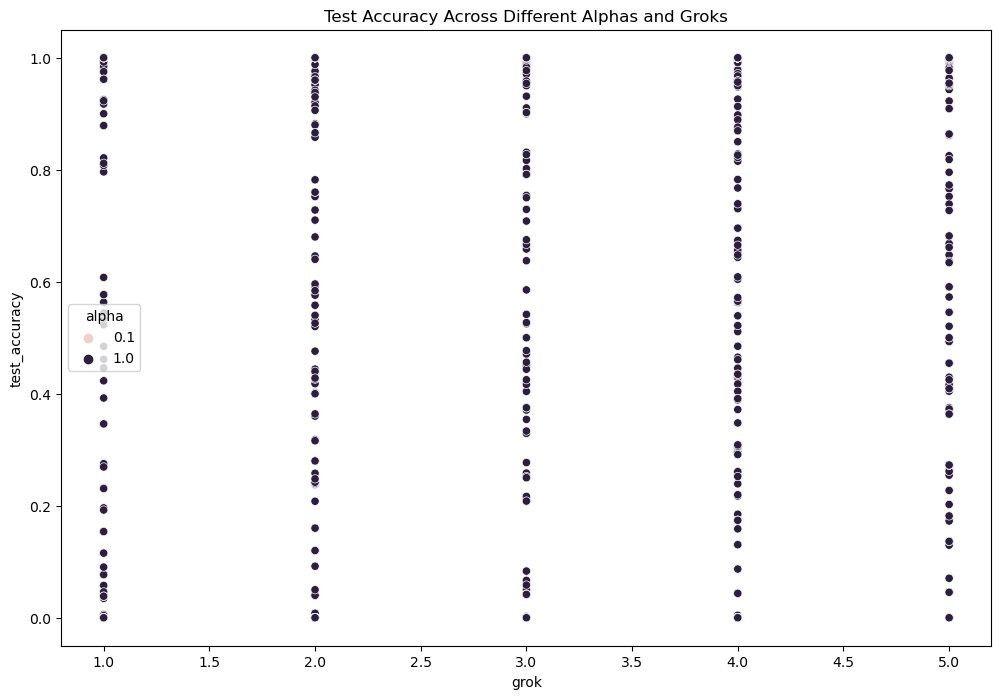

In [3]:
# Initialize a list to store all experiment and task data
experiments_data = []

for experiment_id in range(number_of_experiments):  # replace with actual number of experiments
    experiment_folder = os.path.join(base_folder, f"experiment_{experiment_id}")
    
    for task_id in range(96):
        task_folder = os.path.join(experiment_folder, f"task_{task_id}")
        
        # Load task parameters
        with open(os.path.join(task_folder, "params.json"), 'r') as f:
            params = json.load(f)
        
        # Load task results (modify based on your actual result structure)
        metrics_path = os.path.join(task_folder, "metrics_history.csv")
        if os.path.exists(metrics_path):
            metrics = pd.read_csv(metrics_path)
            
            # Here, suppose you have columns 'train_loss', 'test_loss' etc. in your metrics CSV
            last_row = metrics.iloc[-1]  # assuming you are interested in the last row of metrics
            
            experiments_data.append({
                'experiment_id': experiment_id,
                'task_id': task_id,
                'alpha': params['alpha'],
                'grok': params['grok'],
                'grok_label': params['grok_label'],
                'train_loss': last_row.get('train_loss', None),
                'train_accuracy': last_row.get('train_accuracy', None),
                'test_loss': last_row.get('test_loss', None),
                'test_accuracy': last_row.get('test_accuracy', None),
                'grok_loss':  last_row.get('grok_loss', None),
                'grok_accuracy': last_row.get('grok_accuracy', None),
            })

# Convert the list of dicts to a DataFrame
df = pd.DataFrame(experiments_data)

# Basic plotting for visual inspection (modify based on your specific needs)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='grok', y='test_accuracy', hue='alpha')
plt.title('Test Accuracy Across Different Alphas and Groks')
plt.show()

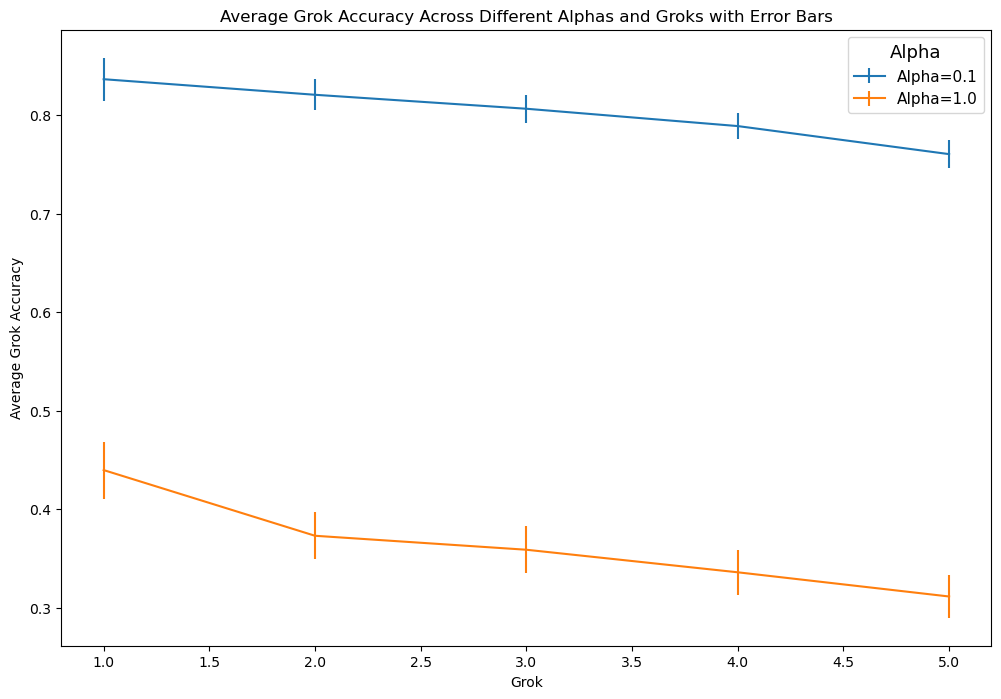

In [4]:
# Group by 'alpha', 'grok' and calculate the mean and standard error of the mean (sem) for 'grok_accuracy'
grouped_df = df.groupby(['alpha', 'grok'])['grok_accuracy'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(12, 8))

for alpha in grouped_df['alpha'].unique():
    alpha_df = grouped_df[grouped_df['alpha'] == alpha]
    plt.errorbar(alpha_df['grok'], alpha_df['mean'], yerr=alpha_df['sem'], label=f'Alpha={alpha}')

plt.xlabel('Grok')
plt.ylabel('Average Grok Accuracy')
plt.title('Average Grok Accuracy Across Different Alphas and Groks with Error Bars')
plt.legend(title='Alpha', title_fontsize='13', fontsize='11')
plt.show()

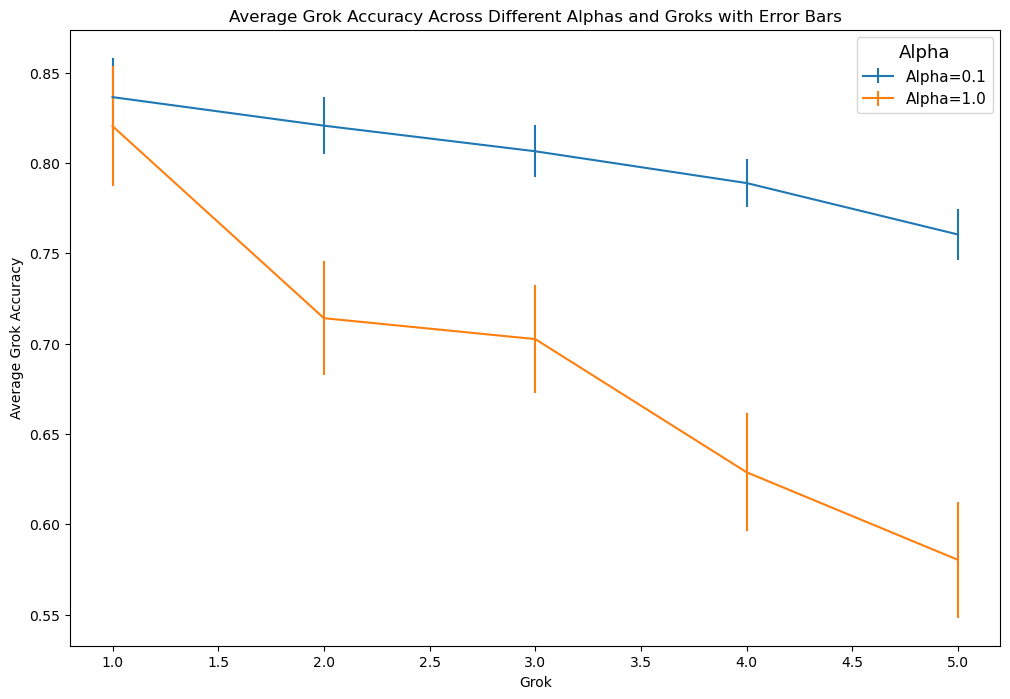

In [5]:
filtered_df = df[df['test_accuracy'] > 0.99]

plt.figure(figsize=(12, 8))

# Grouping by 'alpha' and 'grok' and calculating mean and sem for 'grok_accuracy'
grouped_df = filtered_df.groupby(['alpha', 'grok'])['grok_accuracy'].agg(['mean', 'sem']).reset_index()

for alpha in grouped_df['alpha'].unique():
    alpha_df = grouped_df[grouped_df['alpha'] == alpha]
    plt.errorbar(alpha_df['grok'], alpha_df['mean'], yerr=alpha_df['sem'], label=f'Alpha={alpha}')

plt.xlabel('Grok')
plt.ylabel('Average Grok Accuracy')
plt.title('Average Grok Accuracy Across Different Alphas and Groks with Error Bars')
plt.legend(title='Alpha', title_fontsize='13', fontsize='11')
plt.show()

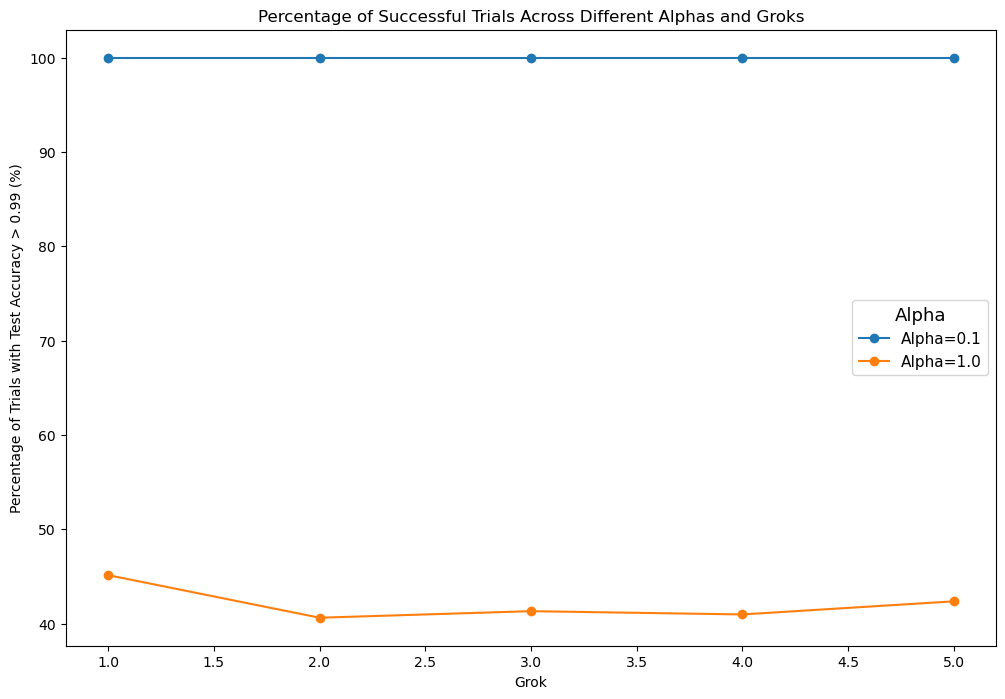

In [6]:
# Calculating the total number of trials per 'grok' and 'alpha'
total_counts = df.groupby(['alpha', 'grok']).size().reset_index(name='total')

# Filtering rows where 'test_accuracy' is above 0.9 and calculating the count per 'grok' and 'alpha'
successful_counts = df[df['test_accuracy'] > 0.99].groupby(['alpha', 'grok']).size().reset_index(name='successful')

# Merging the two DataFrames on 'grok' and 'alpha' to align successful and total counts
percentages_df = pd.merge(total_counts, successful_counts, on=['alpha', 'grok'], how='left').fillna(0)

# Calculating the percentage of successful trials
percentages_df['percentage'] = (percentages_df['successful'] / percentages_df['total']) * 100

plt.figure(figsize=(12, 8))

# Plotting a line for each unique 'alpha' in the DataFrame
for alpha in percentages_df['alpha'].unique():
    alpha_df = percentages_df[percentages_df['alpha'] == alpha]
    plt.plot(alpha_df['grok'], alpha_df['percentage'], label=f'Alpha={alpha}', marker='o')

plt.xlabel('Grok')
plt.ylabel('Percentage of Trials with Test Accuracy > 0.99 (%)')
plt.title('Percentage of Successful Trials Across Different Alphas and Groks')
plt.legend(title='Alpha', title_fontsize='13', fontsize='11')
plt.show()

In [7]:
# Filtering rows where 'test_accuracy' is above 0.9 and grouping by 'experiment_id' to count them
successful_counts = df[df['test_accuracy'] > 0.99].groupby('experiment_id').size().reset_index(name='successful_count')

# If there are experiments with no successful trials, adding them to successful_counts DataFrame with a count of 0
all_experiments = df['experiment_id'].unique()
missing_experiments = set(all_experiments) - set(successful_counts['experiment_id'])
missing_df = pd.DataFrame(list(missing_experiments), columns=['experiment_id'])
missing_df['successful_count'] = 0

# Concatenating the DataFrames
successful_counts = pd.concat([successful_counts, missing_df], ignore_index=True)

# Finding the experiment with the minimum count
min_successful_experiment = successful_counts.loc[successful_counts['successful_count'].idxmin()]

experiment_id = min_successful_experiment['experiment_id']
successful_count = min_successful_experiment['successful_count']

print(f"The experiment with ID {experiment_id} had the fewest successful trials with {successful_count} trials having a test_accuracy above 0.99.")

The experiment with ID 23 had the fewest successful trials with 26 trials having a test_accuracy above 0.99.


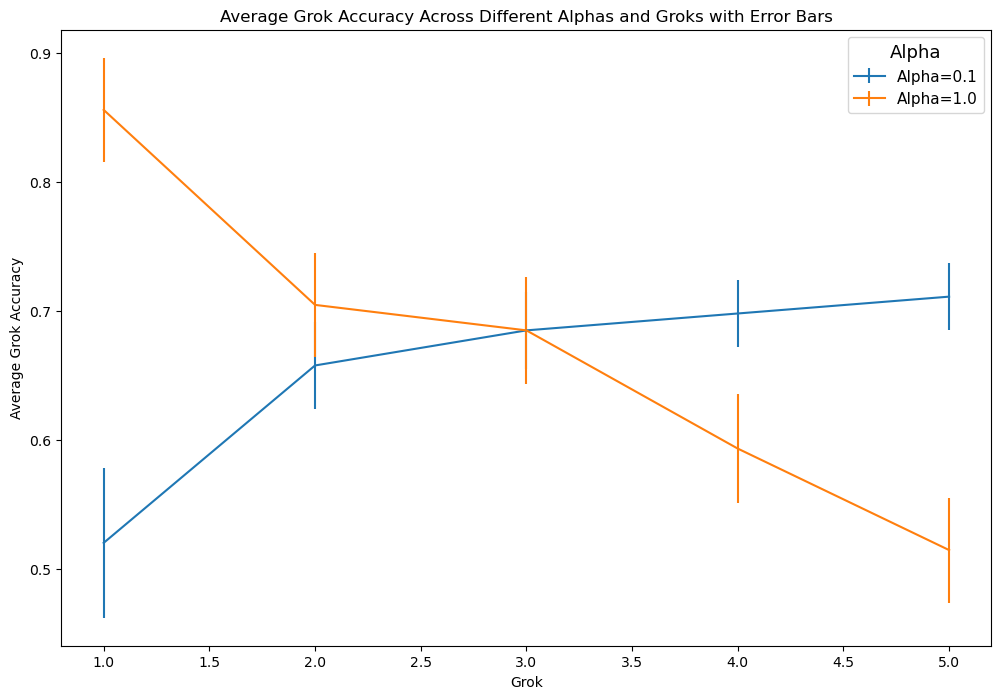

In [8]:
# Initialize a list to store filtered rows
top_25_df_list = []

# For each experiment, get the top 25 rows with the lowest 'testing_loss'
for experiment_id in df['experiment_id'].unique():
    experiment_df = df[df['experiment_id'] == experiment_id]
    top_25_df = experiment_df.nsmallest(25, 'test_loss')
    top_25_df_list.append(top_25_df)

# Concatenate the filtered DataFrames
top_25_df = pd.concat(top_25_df_list, ignore_index=True)

# Group by 'alpha', 'grok' and calculate the mean and standard error of the mean (sem) for 'grok_accuracy'
grouped_df = top_25_df.groupby(['alpha', 'grok'])['grok_accuracy'].agg(['mean', 'sem']).reset_index()

plt.figure(figsize=(12, 8))

# Plot each alpha
for alpha in grouped_df['alpha'].unique():
    alpha_df = grouped_df[grouped_df['alpha'] == alpha]
    plt.errorbar(alpha_df['grok'], alpha_df['mean'], yerr=alpha_df['sem'], label=f'Alpha={alpha}')

plt.xlabel('Grok')
plt.ylabel('Average Grok Accuracy')
plt.title('Average Grok Accuracy Across Different Alphas and Groks with Error Bars')
plt.legend(title='Alpha', title_fontsize='13', fontsize='11')
plt.show()

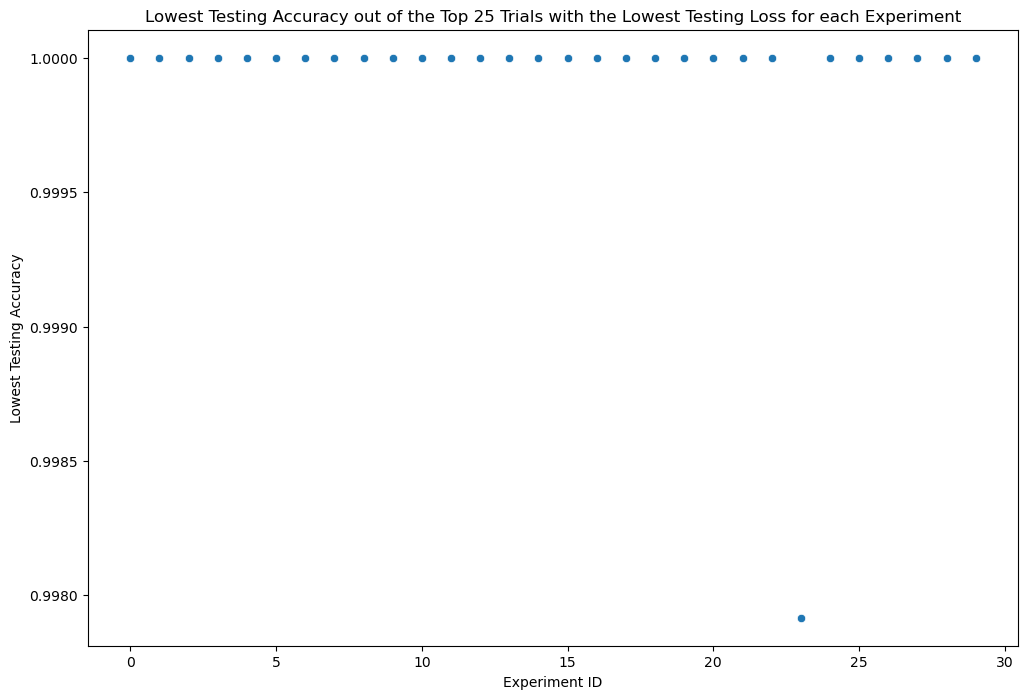

In [9]:
# For each experiment, get the row with the lowest 'testing_accuracy' out of the top 25 trials with the lowest 'testing_loss'
lowest_accuracy_df_list = []

for experiment_id in df['experiment_id'].unique():
    experiment_df = df[df['experiment_id'] == experiment_id]
    top_25_df = experiment_df.nsmallest(25, 'test_loss')
    lowest_accuracy_row = top_25_df.nsmallest(1, 'test_accuracy')
    lowest_accuracy_df_list.append(lowest_accuracy_row)

lowest_accuracy_df = pd.concat(lowest_accuracy_df_list, ignore_index=True)

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=lowest_accuracy_df, x='experiment_id', y='test_accuracy')
plt.xlabel('Experiment ID')
plt.ylabel('Lowest Testing Accuracy')
plt.title('Lowest Testing Accuracy out of the Top 25 Trials with the Lowest Testing Loss for each Experiment')
plt.show()